# ANN-to-SNN conversion - CNN

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/ANN2SNN2.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/ANN2SNN2.ipynb)

This notebook demonstrates how to transform a CNN trained using tensorflow/keras into an SNN network usable in ANNarchy.

The CNN is adapted from the original model used in:

> Diehl et al. (2015) "Fast-classifying, high-accuracy spiking deep networks through weight and threshold balancing" Proceedings of IJCNN. doi: 10.1109/IJCNN.2015.7280696

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(f"Tensorflow {tf.__version__}")

Tensorflow 2.16.2


In [3]:
# Download data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()

# Normalize inputs
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# One-hot output vectors
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

## Training an ANN in tensorflow/keras

The `tensorflow.keras` convolutional network is built using the functional API. 

The CNN has three 5\*5 convolutional layers with ReLU, each followed by 2\*2 max-pooling, **no bias**, dropout at 0.25, and a softmax output layer with 10 neurons. We use the standard SGD optimizer and the categorical crossentropy loss for classification.

In [4]:
def create_cnn():
    
    inputs = tf.keras.Input(shape = (28, 28, 1))
    x = tf.keras.layers.Conv2D(
        16, 
        kernel_size=(5,5),
        activation='relu',
        padding = 'same',
        use_bias=False)(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        kernel_size=(5,5),
        activation='relu',
        padding = 'same',
        use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        kernel_size=(5,5),
        activation='relu',
        padding = 'same',
        use_bias=False)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        10,
        activation='softmax',
        use_bias=False)(x)

    # Create functional model
    model= tf.keras.Model(inputs, x)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    # Loss function
    model.compile(
        loss='categorical_crossentropy', # loss function
        optimizer=optimizer, # learning rule
        metrics=['accuracy'] # show accuracy
    )
    print(model.summary())

    return model

In [5]:
# Create model
model = create_cnn()

# Train model
history = model.fit(
    X_train, T_train,       # training data
    batch_size=128,          # batch size
    epochs=20,              # Maximum number of epochs
    validation_split=0.1,   # Percentage of training data used for validation
)

model.save("runs/cnn.keras")

# Test model
predictions_keras = model.predict(X_test, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, T_test, verbose=0)
print(f"Test accuracy: {test_accuracy}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │       102,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,160 (524.06 KB)

 Trainable params: 134,160 (524.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.3815 - loss: 1.9014 - val_accuracy: 0.9252 - val_loss: 0.3057
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.8914 - loss: 0.3637 - val_accuracy: 0.9595 - val_loss: 0.1558
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9317 - loss: 0.2245 - val_accuracy: 0.9687 - val_loss: 0.1192
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9496 - loss: 0.1717 - val_accuracy: 0.9720 - val_loss: 0.0966
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9555 - loss: 0.1487 - val_accuracy: 0.9770 - val_loss: 0.0871
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9612 - loss: 0.1273 - val_accuracy: 0.9783 - val_loss: 0.0772
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9655 - loss: 0.1168 - val_accuracy: 0.9790 - val_loss: 0.0766
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9694 - loss: 0.10

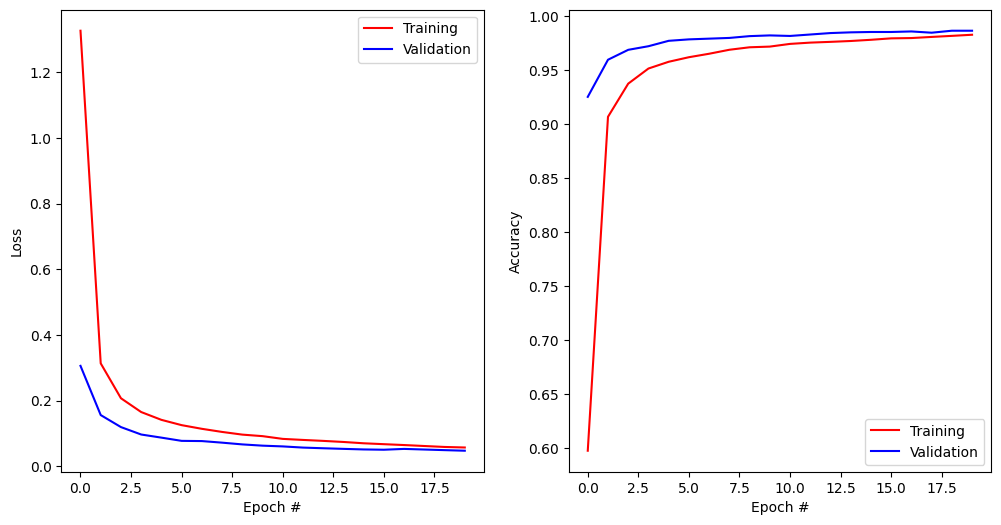

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Initialize the ANN-to-SNN converter

We now create an instance of the ANN-to-SNN conversion object. 

In [7]:
from ANNarchy.extensions.ann_to_snn_conversion import ANNtoSNNConverter

snn_converter = ANNtoSNNConverter(
    input_encoding='IB', 
    hidden_neuron='IaF',
    read_out='spike_count',
)

ANNarchy 5.0 (5.0.0) on darwin (posix).


In [8]:
net = snn_converter.load_keras_model("runs/cnn.keras", show_info=True)

* Input layer: input_layer, (28, 28, 1)
* InputLayer skipped.
* Conv2D layer: conv2d, (28, 28, 16) 
* MaxPooling2D layer: max_pooling2d, (14, 14, 16) 
* Conv2D layer: conv2d_1, (14, 14, 64) 
* MaxPooling2D layer: max_pooling2d_1, (7, 7, 64) 
* Conv2D layer: conv2d_2, (7, 7, 64) 
* MaxPooling2D layer: max_pooling2d_2, (3, 3, 64) 
* Dropout skipped.
* Flatten skipped.
* Dense layer: dense, 10 
    weights: (10, 576)
    mean -0.0003130047698505223, std 0.069309763610363
    min -0.23668308556079865, max 0.20495571196079254



In [9]:
predictions_snn = snn_converter.predict(X_test[:300], duration_per_sample=200)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [09:32<00:00,  1.91s/it]


Using the recorded predictions, we can now compute the accuracy using scikit-learn for all presented samples.

In [10]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(t_test[:300], predictions_snn))
print("Test accuracy of the SNN:", accuracy_score(t_test[:300], predictions_snn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.90      0.95        41
           2       1.00      1.00      1.00        32
           3       0.96      1.00      0.98        24
           4       1.00      0.97      0.99        37
           5       1.00      1.00      1.00        29
           6       0.96      1.00      0.98        24
           7       1.00      0.97      0.99        34
           8       0.75      1.00      0.86        21
           9       1.00      0.91      0.95        34

    accuracy                           0.97       300
   macro avg       0.97      0.98      0.97       300
weighted avg       0.98      0.97      0.97       300

Test accuracy of the SNN: 0.97
